# Load the libraries

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from Modules.Metrics import Accuracy, Precision, Recall, F1score
from Modules.SupervisedLearning import Perceptron
from Modules.Metrics import Accuracy
from Modules.Visualizers import PCA

# Load Railway dataset

<IPython.core.display.Javascript object>


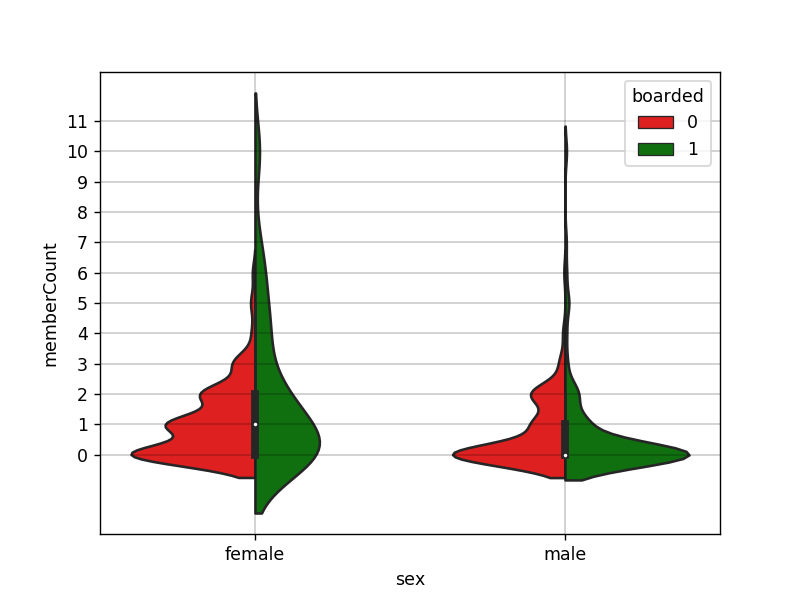

<IPython.core.display.Javascript object>


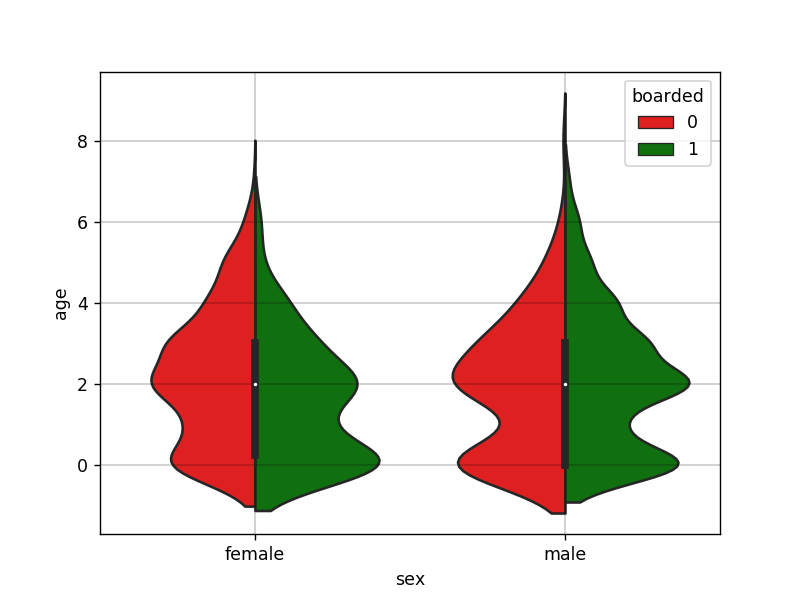

<IPython.core.display.Javascript object>


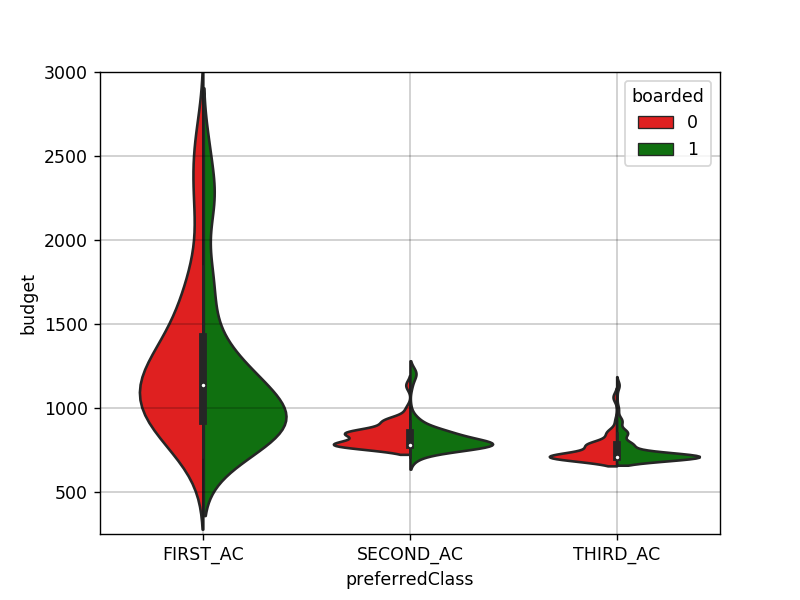

In [2]:
railway_data = pd.read_csv("data/railwayBookingList.csv")

railway_data = railway_data.dropna()

fig, ax = plt.subplots()
sns.violinplot(x = railway_data["sex"], y = railway_data["memberCount"], hue = railway_data["boarded"],
               split = True, palette = {0: "r", 1: "g"})
plt.yticks(range(0, 12))
ax.grid(linestyle = "-", linewidth = '0.2', color='black')

fig, ax = plt.subplots()
sns.violinplot(x = railway_data["sex"], y = railway_data["age"], hue = railway_data["boarded"],
               split = True, palette = {0: "r", 1: "g"})
ax.grid(linestyle = "-", linewidth = '0.2', color='black')

fig, ax = plt.subplots()
sns.violinplot(x = railway_data["preferredClass"], y = railway_data["budget"], hue = railway_data["boarded"],
               split = True, palette = {0: "r", 1: "g"})
plt.ylim(250, 3000)
ax.grid(linestyle = "-", linewidth = '0.2', color='black')

railway_data.loc[railway_data["sex"] == "male", "sex"] = 1
railway_data.loc[railway_data["sex"] == "female", "sex"] = 0

railway_data.loc[railway_data["preferredClass"] == "FIRST_AC", "preferredClass"] = 0
railway_data.loc[railway_data["preferredClass"] == "SECOND_AC", "preferredClass"] = 1
railway_data.loc[railway_data["preferredClass"] == "THIRD_AC", "preferredClass"] = 2

# Construct new feature indicating amount paid by the person (is 0 if not boarded, else is split equally among the members)
# railway_data["fare"] = railway_data["budget"] / (railway_data["memberCount"] + 1)

x = railway_data.drop(["caseID", "boarded"], axis = 1).values
y = railway_data["boarded"].values

x_ = (x - x.mean(axis = 0)) / np.sqrt(x.var(axis = 0))

x_train = x[:1178, :]
y_train = y[:1178]

x_test = x[1178:, :]
y_test = y[1178:]

# Perceptron

In [16]:
classifier = Perceptron()
predictions = classifier.Fit(x_train, y_train, epochs = 1)
Accuracy(predictions, y_train)

0.599320882852292

<IPython.core.display.Javascript object>


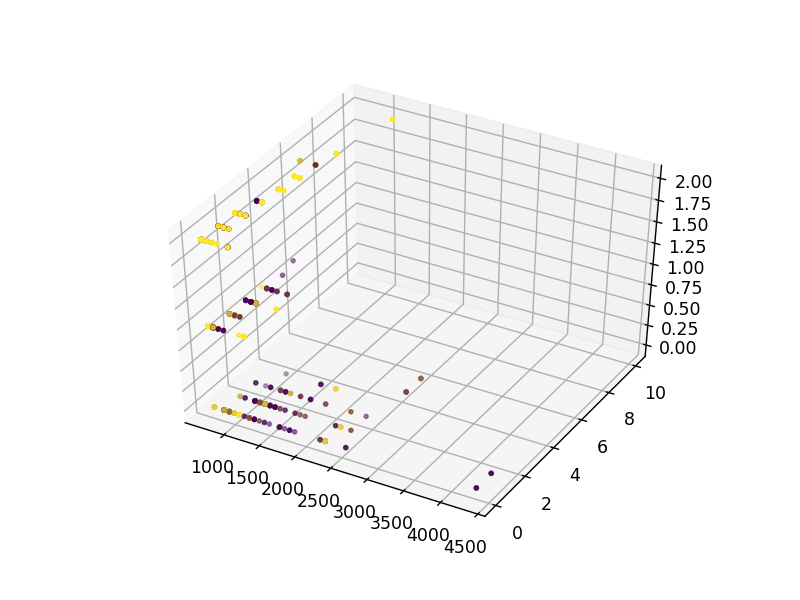

In [6]:
# x_train_, x_test_, p = PCA(x_train, x_test, p = 2)
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c = y_train, marker = ".")

In [5]:
Accuracy(predictions, y_train)

0.599320882852292